# EndToEnd IAM Dataset training

### Collab
Install Requirements, download and unload dataset

In [ ]:
!pip install transformers datasets evaluate jiwer accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
# to be used in google collab, mount google drive to get training data and unzip it

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av /content/drive/MyDrive/Master/handwritting/IAM-data.zip /content/

'/content/drive/MyDrive/Master/handwritting/IAM-data.zip' -> '/content/IAM-data.zip'


In [ ]:
img_zip_path = '/content/IAM-data.zip'
zip_ref = zipfile.ZipFile(img_zip_path, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

### Data

In [1]:
# usual imports
import pandas as pd
import os
import torch
from tqdm.notebook import tqdm
import csv

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
current_directory = os.getcwd()


In [3]:
# creates new txt file with format to be read with pandas
def create_new_text_directory():
    file_path = "IAM-data/iam_lines_gt.txt"
    file_path = os.path.join(current_directory, file_path)

    with open(file_path, 'r') as file:
        # Read the entire file
        content = file.read()
        content = content.replace("\n", "\t")
        content = content.replace("\t\t", "\n")

    file_path = "IAM-data/iam_lines_ours.txt"
    file_path = os.path.join(current_directory, file_path)
    with open(file_path, 'w') as file:
        file.write(content)
    return file_path
file_path = create_new_text_directory()

In [4]:
# new text file is read to pandas
df = pd.read_csv(file_path, delimiter='\t', header=None, names=["file_name", "text"], encoding='utf-8', quoting=csv.QUOTE_NONE)
df['length'] = df['text'].str.len()

df.shape

(7458, 3)

In [6]:
# get string legngth 
df['length'] = df['text'].str.len()

In [7]:
df.head()

,file_name,text,length
0,a03-017-07.png,into the pro-communist north and the,36
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though",41
2,a03-017-08.png,pro-western centre and south.,29
3,a03-017-02.png,in Phnom Penh indicate that he still regards,44
4,a03-017-06.png,at the cost of virtual partition of the country,47


In [8]:
df['length'].value_counts()

42    408
41    403
40    395
43    373
39    362
     ... 
3       3
75      2
4       1
1       1
74      1
Name: length, Length: 73, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
# split the data into training, evaluation, and testing data
train_df, test_df = train_test_split(df, test_size=0.2,random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df, eval_df = train_test_split(test_df, test_size=0.5,random_state=42)
test_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(eval_df.shape)

(5966, 3)
(746, 3)
(746, 3)


In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image

In [11]:
# Create a torch.Dataset class to load the data so it can be used to train the model transformations are made here.
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)
    
    # called every time a single pair of image and label is fetched
    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + file_name).convert("RGB")
        # resizes and normalizes the images
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # converts the text to tokens understandable by the decoder.
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # labels are of a fixed size, but they can include tokens that can be ignored
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        # dictionary with the corresponding normalized and resized pixel values and tokens as labels.
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [12]:
from transformers import TrOCRProcessor, ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel
from datasets import load_dataset
from transformers import TrOCRProcessor

In [13]:
# procesor is used to transform the data for training.
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [17]:
train_dataset = IAMDataset(root_dir=os.path.join(current_directory, 'IAM-data/img/'),
                           df=train_df,
                           processor=processor)
test_dataset = IAMDataset(root_dir=os.path.join(current_directory, 'IAM-data/img/'),
                           df=test_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=os.path.join(current_directory, 'IAM-data/img/'),
                           df=eval_df,
                           processor=processor)

In [35]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 5966
Number of validation examples: 746
Number of test examples: 746


In [19]:
# checked if there existed labels with more than a certain length of characters, only used for debugging some errors
def check_tokenization():
    for i in range(len(train_dataset)):
        encoding = train_dataset[i]
        for k,v in encoding.items():
            if(k == 'labels' and v.shape[0] != 128):
                print(i)
# check_tokenization()

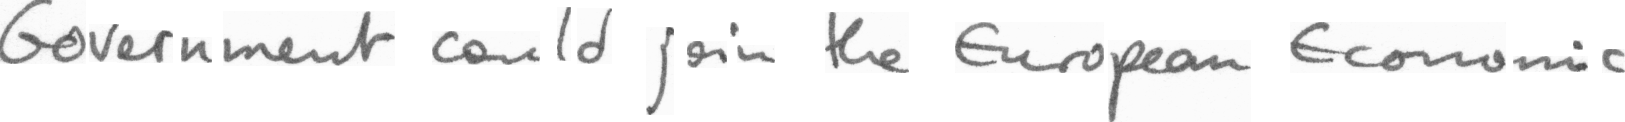

In [20]:
# fetches an item from a dataset and shoes the image
encoding = train_dataset[0]
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [21]:
# corresponding tokens for the label of the fetched item
encoding['labels']

tensor([    0, 28747,   115,  1962,     5,   796,  4713,     2,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [22]:
# converts labels back into text
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Government could join the European Economic


### Model

In [23]:
from transformers import VisionEncoderDecoderModel
# model initialization of a base stage of the trocr model proposed to fine tune.
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:

# make sure the procesor and the model have the same configuration to make the training compatible
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# beam search configuration
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

### Training

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# training arguments for this type of trainer
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [ ]:
# training_args.to_dict()

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-29-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
# computes Character Error Rate metric for a prediction
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:

from transformers import default_data_collator #used to create batches from a dataset

# create a new trainer instance, with the model, processors, training a rguments, metrics, and datasets
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,1.641300,1.431792,0.196141
400,2.267900,1.404459,0.197723
600,1.046700,1.231603,0.175138
800,0.663300,1.077340,0.132722
1000,0.682300,0.937393,0.112447
1200,0.610000,0.885717,0.098498
1400,0.836700,0.823649,0.093215
1600,0.481700,0.745010,0.078823
1800,0.332600,0.696018,0.072244
2000,0.328700,0.624651,0.060066


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


TrainOutput(global_step=2238, training_loss=0.9873476393980252, metrics={'train_runtime': 7483.9853, 'train_samples_per_second': 2.392, 'train_steps_per_second': 0.299, 'total_flos': 1.5837858775928144e+19, 'train_loss': 0.9873476393980252, 'epoch': 3.0})

In [ ]:
len(train_dataset)

5966

In [ ]:
len(test_dataset)

746

In [ ]:
trai

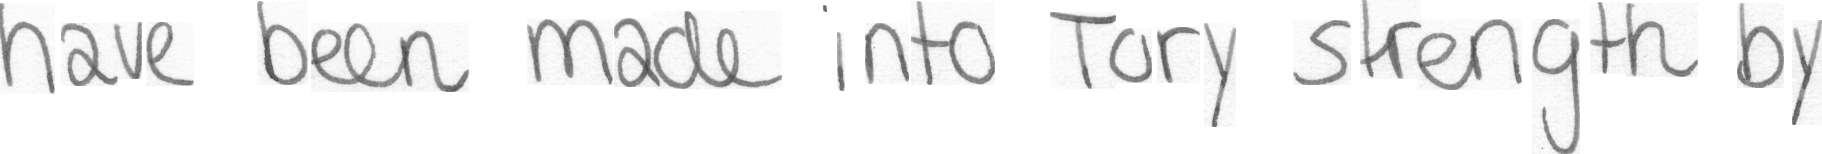

In [ ]:
encoding = test_dataset[sample]
image = Image.open(test_dataset.root_dir + test_df['file_name'][sample]).convert("RGB")
image

In [ ]:
# real labels
pred_labels = encoding['labels']
pred_labels[pred_labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.tokenizer.decode(pred_labels, skip_special_tokens=True)
print(label_str)

have been made into Tory strength by


In [ ]:
encoding['labels']

tensor([    0, 11990,    57,   156,    88, 10886,  2707,    30,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [ ]:
# predicted labels
pred_labels = model.generate(torch.unsqueeze(encoding['pixel_values'], 0).to(device)).to('cpu')
label_str = processor.tokenizer.batch_decode(pred_labels, skip_special_tokens=True)
print(label_str)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['have been made into Tory strength by']


### Metrics
Run ```tensorboard --logdir=runs``` to see training metrics and loss.

### EVALUATION on Test Data

In [25]:
# data loader to create batches for inference
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=8)

In [26]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
    print(k, v.shape)


pixel_values torch.Size([8, 3, 384, 384])
labels torch.Size([8, 128])


In [26]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
    print(k, v.shape)


pixel_values torch.Size([8, 3, 384, 384])
labels torch.Size([8, 128])


In [27]:
# load model weights
model = VisionEncoderDecoderModel.from_pretrained("folders2/checkpoint-9000")


In [28]:
# move the model to GPU device
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [32]:
# Load Character Error Rate metric for evaluation

from datasets import load_metric

cer = load_metric("cer")

C:\Users\jl\AppData\Local\Temp\ipykernel_8576\1992848031.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer = load_metric("cer")


In [33]:
print("Running evaluation...")

for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to(device)
    outputs = model.generate(pixel_values)

    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["labels"]
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    # add batch to metric
    cer.add_batch(predictions=pred_str, references=label_str)

final_score = cer.compute()

Running evaluation...


  0%|          | 0/94 [00:00<?, ?it/s]

C:\Users\jl\Miniconda3\envs\torch\lib\site-packages\transformers\generation\utils.py:1346: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [34]:
print("Character error rate on test set:", final_score)

Character error rate on test set: 0.11508642602948653
